# 1. Importing library & loading spectra

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [24]:
# loading UV spectra for compounds in basis set, these spectra are calibrated to 0.5mM concentration.
X = pd.read_csv('data/UV_spectra/Basis_set_11refs_0.5mM.csv', index_col=0)
X

,S1,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Unnamed: 0,,,,,,,,,,,
225,0.496661,0.033329,0.317732,0.311641,0.113938,0.031798,0.012809,0.238907,0.074916,0.038487,0.295471
226,0.533305,0.030744,0.340653,0.325110,0.116229,0.031910,0.013511,0.264031,0.084414,0.042813,0.322280
227,0.568816,0.026943,0.364577,0.336283,0.118004,0.031724,0.014554,0.288200,0.091795,0.041413,0.348155
228,0.603714,0.022911,0.387238,0.346959,0.120316,0.033225,0.016315,0.313416,0.098365,0.041164,0.376716
229,0.630305,0.020451,0.406334,0.353761,0.124525,0.035613,0.015704,0.329488,0.099961,0.042338,0.394488
...,...,...,...,...,...,...,...,...,...,...,...
306,-0.003373,0.000177,0.002244,0.004789,0.009644,0.002444,-0.001783,-0.001881,-0.007966,0.003887,0.005432
307,-0.005019,0.001130,0.002429,0.003974,0.008509,0.001954,-0.001598,-0.003030,-0.008550,0.003073,0.004615
308,-0.004339,0.001880,0.002247,0.004993,0.009708,0.002824,-0.000761,-0.002678,-0.008532,0.003762,0.004634


# 2. grouping similar products based on spectra similarity 

In [ ]:
# Calculate correlation matrix for all spectra pairs
corr_mat = X.corr()
corr_mat

,S1,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
S1,1.000000,0.126457,0.945919,0.800142,0.500854,0.174737,0.134574,0.868688,0.507567,0.191866,0.713290
P1,0.126457,1.000000,0.304622,0.410683,0.914666,0.970141,0.965947,0.400049,0.910039,0.962817,0.718427
P2,0.945919,0.304622,1.000000,0.926282,0.653718,0.307880,0.270980,0.971890,0.641200,0.315873,0.862794
P3,0.800142,0.410683,0.926282,1.000000,0.704638,0.352849,0.318551,0.981070,0.660932,0.351376,0.912233
P4,0.500854,0.914666,0.653718,0.704638,1.000000,0.909151,0.890449,0.715252,0.994426,0.907637,0.925111
P5,0.174737,0.970141,0.307880,0.352849,0.909151,1.000000,0.997587,0.364463,0.923387,0.998743,0.685951
P6,0.134574,0.965947,0.270980,0.318551,0.890449,0.997587,1.000000,0.326909,0.904634,0.996764,0.655609
P7,0.868688,0.400049,0.971890,0.981070,0.715252,0.364463,0.326909,1.000000,0.687716,0.364922,0.923451
P8,0.507567,0.910039,0.641200,0.660932,0.994426,0.923387,0.904634,0.687716,1.000000,0.923580,0.903902
P9,0.191866,0.962817,0.315873,0.351376,0.907637,0.998743,0.996764,0.364922,0.923580,1.000000,0.683424


In [ ]:
# for each column in corr_mat, group features with correlation > 0.95
corr_ref = []
corr_ref_pairs = []
for i in range(corr_mat.shape[1]):
    ref_col = corr_mat.columns[i]
    corr_cols = corr_mat.index[corr_mat.iloc[:, i] > 0.95].tolist()
    # only add if the reference column is not already in corr_ref
    if ref_col not in corr_ref:
        corr_ref.append(ref_col)
        corr_ref_pairs.append(corr_cols)

# remove repeated features in corr_ref_pairs, for those who have intersection, keep their union
unique_corr_ref_pairs = []
for pair in corr_ref_pairs:
    is_unique = True
    for unique_pair in unique_corr_ref_pairs:
        if set(pair).intersection(set(unique_pair)):
            unique_pair.extend([i for i in pair if i not in unique_pair])
            is_unique = False
            break
    if is_unique:
        unique_corr_ref_pairs.append(pair)
corr_ref_pairs = unique_corr_ref_pairs

# only keep group with multiple features
corr_ref_pairs = [pair for pair in corr_ref_pairs if len(pair) > 1]
corr_ref_pairs

[['P1', 'P5', 'P6', 'P9'], ['P2', 'P7', 'P3'], ['P4', 'P8']]

# 3. Establishing surrogate spectrum for each cluster by PCA

In [ ]:
# PCA for C1 (P1, P5, P6, P9)
corr_C1 = X[corr_ref_pairs[0]]
pca_p1 = PCA(n_components=len(corr_ref_pairs[0]))
pca_p1.fit(corr_C1)
print(pca_p1.explained_variance_ratio_)

# PCA for C2 (P2, P3, P7)
corr_C2 = X[corr_ref_pairs[1]]
pca_p2 = PCA(n_components=len(corr_ref_pairs[1]))
pca_p2.fit(corr_C2)
print(pca_p2.explained_variance_ratio_)

# PCA for C3 (P4, P8)
corr_C3 = X[corr_ref_pairs[2]]
pca_p3 = PCA(n_components=len(corr_ref_pairs[2]))
pca_p3.fit(corr_C3)
print(pca_p3.explained_variance_ratio_)

[9.93070957e-01 5.87831525e-03 7.92299542e-04 2.58427967e-04]
[0.97185259 0.0264619  0.00168551]
[0.99721369 0.00278631]


In [ ]:
# create new features based on PCA components
old_features = X.columns
new_features = [i for i in X.columns if i not in corr_ref]

for i in range(len(corr_ref_pairs[0])):
    X[f'PCA1_{i+1}'] = (corr_C1 * pca_p1.components_[i]).sum(axis=1)
    
for i in range(len(corr_ref_pairs[1])):
    X[f'PCA2_{i+1}'] = (corr_C2 * pca_p2.components_[i]).sum(axis=1)

for i in range(len(corr_ref_pairs[2])):
    X[f'PCA3_{i+1}'] = (corr_C3 * pca_p3.components_[i]).sum(axis=1)


In [ ]:
# export the new basis set with PCA features
X
# X.to_csv('data/UV_spectra/Basis_set_11refs_with_PCA_0.5mM.csv')

,S1,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,PCA1_1,PCA1_2,PCA1_3,PCA1_4,PCA2_1,PCA2_2,PCA2_3,PCA3_1,PCA3_2
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
225,0.496661,0.033329,0.317732,0.311641,0.113938,0.031798,0.012809,0.238907,0.074916,0.038487,0.295471,0.057978,0.015680,-0.012555,-0.001537,0.500738,0.057719,-0.032871,0.133281,0.028821
226,0.533305,0.030744,0.340653,0.325110,0.116229,0.031910,0.013511,0.264031,0.084414,0.042813,0.322280,0.060295,0.011794,-0.013870,-0.003461,0.536294,0.057016,-0.024313,0.141663,0.023802
227,0.568816,0.026943,0.364577,0.336283,0.118004,0.031724,0.014554,0.288200,0.091795,0.041413,0.348155,0.058607,0.008561,-0.012023,-0.002556,0.570894,0.053809,-0.015715,0.148173,0.019897
228,0.603714,0.022911,0.387238,0.346959,0.120316,0.033225,0.016315,0.313416,0.098365,0.041164,0.376716,0.058844,0.004560,-0.010247,-0.000991,0.604897,0.051301,-0.005671,0.154481,0.016944
229,0.630305,0.020451,0.406334,0.353761,0.124525,0.035613,0.015704,0.329488,0.099961,0.042338,0.394488,0.059931,0.001794,-0.011404,0.000836,0.629798,0.046583,-0.000488,0.158569,0.018829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,-0.003373,0.000177,0.002244,0.004789,0.009644,0.002444,-0.001783,-0.001881,-0.007966,0.003887,0.005432,0.003121,-0.001022,-0.003661,0.000331,0.003036,0.001545,-0.004461,0.001072,0.012462
307,-0.005019,0.001130,0.002429,0.003974,0.008509,0.001954,-0.001598,-0.003030,-0.008550,0.003073,0.004615,0.002697,0.000142,-0.003125,0.000176,0.002166,0.000609,-0.005081,-0.000140,0.012062
308,-0.004339,0.001880,0.002247,0.004993,0.009708,0.002824,-0.000761,-0.002678,-0.008532,0.003762,0.004634,0.004216,0.000481,-0.002860,0.000243,0.002736,0.001529,-0.005227,0.000713,0.012904


# 4. Viualization of grouped spectra and PCA components 

## UV spectra for each group

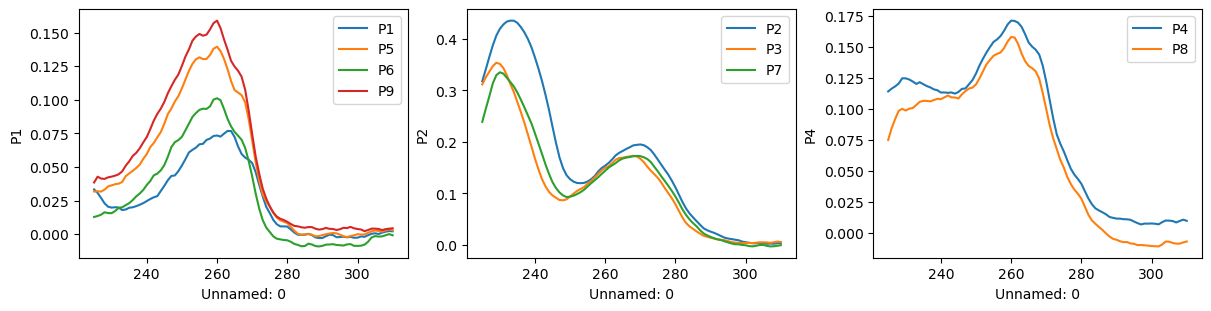

In [21]:
fig_pca1, ax_pca1 = plt.subplots(1,len(corr_ref_pairs), constrained_layout=True, figsize=(12, 3))

for i in range(len(corr_ref_pairs)):
    for ind, col in X[corr_ref_pairs[i]].items():
        axesSub = sns.lineplot(x=X.index, y=col, label=ind, ax=ax_pca1[i])

## Spectra of PCA component

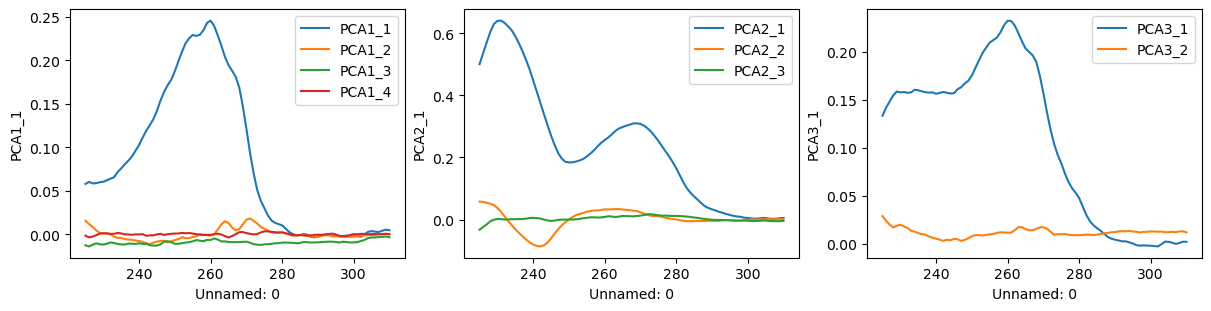

In [22]:
pca_features = [['PCA1_1', 'PCA1_2', 'PCA1_3', 'PCA1_4'],
                ['PCA2_1', 'PCA2_2', 'PCA2_3'],
                ['PCA3_1', 'PCA3_2']]
fig_pca1, ax_pca1 = plt.subplots(1,len(pca_features), constrained_layout=True, figsize=(12, 3))

for i in range(len(pca_features)):
    for ind, col in X[pca_features[i]].items():
        axesSub = sns.lineplot(x=X.index, y=col, label=ind, ax=ax_pca1[i])